In [1]:
%matplotlib inline

In [2]:
from lab_tsp_insertion import *
import math
import matplotlib.pyplot as plt
import sys

In [30]:
from functools import lru_cache
class TSPSolution(object):
    def __init__(self, instance: list, tour:list, distance:int):
        self.tour = tour
        self.n_cities = len(tour)
        self.inst = instance
        self.distance = self.calculate_solution_distance()
    
    def __repr__(self):
        return f"Tour={self.tour}, distance={self.distance}, n_cities={self.n_cities}"
    
    def get_n_cities(self):
        return self.n_cities
    
    @lru_cache(maxsize=1024 * 1024 * 1024)
    def get_distance(self, x, y):
        # This function takes the city number, not index into array
        c1x, c1y = self.inst[x]
        c2x, c2y = self.inst[y]
        return ((c2x - c1x) ** 2 + (c2y - c1y) ** 2)
    
    def copy(self):
        return TSPSolution(self.inst, self.tour.copy(), self.distance)
    
    @lru_cache(maxsize=1024 * 1024 * 1024)
    def is_valid_swap(self, x:int, y:int):
        x, y = min(x, y), max(x, y)
        x1 = (x + 1) % self.n_cities
        y1 = (y + 1) % self.n_cities
        return x != y and x != y1 and x != x1 and y != y1 and y != x1 and y1 != x1
    
    def calculate_cost_if_swapped(self, x:int, y: int):
        # If the edges are swapped what would be the cost
        x, y = min(x, y), max(x, y)
        x1 = (x + 1) % self.n_cities
        y1 = (y + 1) % self.n_cities
        xx1 = self.get_distance(self.tour[x], self.tour[x1])
        xy = self.get_distance(self.tour[x], self.tour[y])
        yy1 = self.get_distance(self.tour[y], self.tour[y1])
        x1y1 = self.get_distance(self.tour[x1], self.tour[y1])
        return self.distance - xx1 - yy1 + x1y1 + xy
    
    def get_cache_stats(self):
        return self.get_distance.cache_info(), self.is_valid_swap.cache_info()
    
    def calculate_solution_distance(self):
        dist = 0
        for x in range(self.n_cities):
            y = (x + 1) % self.n_cities
            dist += self.get_distance(self.tour[x], self.tour[y])
        return dist
    
    def perform_swap(self, x, y):
        x, y = min(x, y), max(x, y)
        new_distance = self.calculate_cost_if_swapped(x, y)
        x1 = (x + 1) % self.n_cities
        y1 = (y + 1) % self.n_cities
        assert(x1 < y)
        self.tour[x1], self.tour[y] = self.tour[y], self.tour[x1]
        i = x1 + 1
        j = y - 1
        while (i < j):
            self.tour[i], self.tour[j] = self.tour[j], self.tour[i]
            i += 1
            j -= 1
        #if int(self.calculate_solution_distance()) != int(new_distance):
        #    print(f"New distance should have been {new_distance} but is {self.calculate_solution_distance()}")
        self.distance = new_distance


In [87]:
class TSPHillClimbing(object):
    def __init__(self, inst:dict = None, max_sideways_moves:int=0):
        self.inst = inst
        self.ind = None
        self.g_best_solution = None
        self.g_best_distance = 99999999999999999999999999999999999999999
        self.current_iter_sols = []
        self.current_iter_dist = None
        self.max_sideways_moves = max_sideways_moves
        self.n_sideways_moves = 0
        self.g_best_distance = 999999999999999999999999999999999999999999
        self.g_best_sol = None
        if None != self.inst:
            self.ind = self.get_solution()
            self.update_best_g_instance(self.ind)

            
    def __repr__(self):
        return f"inst = {self.inst}\n\nindividual = {self.ind}\n\n" +\
             f"g_best_solution = {self.g_best_solution}\n\ng_best_distance = {self.g_best_distance}"
    
    def update_best_g_instance(self, instance: TSPSolution):
        self.g_best_solution = instance.copy()
        self.g_best_distance = instance.distance
        
    def get_solution(self):
        #cities, distance = insertion_heuristic1(self.inst)
        cities, distance = randomTours(self.inst)
        return TSPSolution(self.inst, cities, distance)
    
    def check_improving_move(self):
        self.current_iter_dist = self.ind.distance
        self.current_iter_sols = []
        for i in range(self.ind.get_n_cities()):
            for j in range(i+2, self.ind.get_n_cities()):
                if not self.ind.is_valid_swap(i, j):
                    pass
                else:
                    newcost = self.ind.calculate_cost_if_swapped(i, j)
                    if newcost == self.current_iter_dist:
                        self.current_iter_sols.append(list(i, j))
                    elif newcost < self.current_iter_dist:
                        self.current_iter_dist = newcost
                        self.current_iter_sols = [[i,j]]
    
    def iterate_once(self, allow_sideways=False):
        update = False
        old_distance = self.ind.distance
        self.check_improving_move()
        if old_distance == self.current_iter_dist:
            if not allow_sideways or len(self.current_iter_sols) == 0:
                print("All moves are worse")
                return old_distance, self.current_iter_dist, True
            else:
                print("Performing sideways move", self.n_sideways_moves + 1)
                self.n_sideways_moves += 1
                update = True
        if int(self.ind.distance) > int(self.current_iter_dist):
            self.n_sideways_moves = 0
            update = True
        if update:
            toswap = self.current_iter_sols[random.randint(0, len(self.current_iter_sols)-1)]
            x, y = tuple(toswap)
            self.ind.perform_swap(x, y)
        return old_distance, self.current_iter_dist, False
        
    def iterate(self, n_iterations, allow_sideways=False, max_sideways_moves=-1):
        y = []
        rt = []
        self.n_sideways_moves = 0
        t1 = time.perf_counter()
        for i in range(n_iterations):
            sys.stdout.write('.')
            old_distance, current_iter_dist, all_moves_worse = self.iterate_once(allow_sideways)
            if 0 == i:
                y.append(math.sqrt(old_distance))
            rt.append(time.perf_counter() - t1)
            y.append(math.sqrt(current_iter_dist))
            if old_distance == current_iter_dist:
                print(self.n_sideways_moves)
                if all_moves_worse or not allow_sideways or max_sideways_moves < self.n_sideways_moves:
                    if allow_sideways:
                        print("Reached maximum sideways moves")
                    break
            sys.stdout.write(" %f " % (math.sqrt(old_distance) - math.sqrt(current_iter_dist)))
        print("iterations done: ", i)
        print('-' * 80)
        fig, ax = plt.subplots(2)
        ax[0].plot(y, label='distance')
        ax[1].plot(rt, label='runtime')
        #print(rt, y)
        fig.legend()
        plt.show()
        
    def restart_and_iterate(self, n_iterations=100, n_restarts:int=5, allow_sideways=False, max_sideways_moves=-1):
        for i in range(n_restarts):
            self.ind = self.get_solution()
            #print(math.sqrt(self.ind.distance))
            self.update_best_g_instance(self.ind)
            self.iterate(n_iterations, allow_sideways, max_sideways_moves)
            #print(math.sqrt(self.ind.distance))
                

In [88]:
random.seed(5)
def main():
    inst = readInstance('TSPData/inst-0.tsp')
    tsp = TSPHillClimbing(inst)
    tsp.restart_and_iterate(10000, 5, True, 10)
    print('-' * 80)
    return tsp

. 37697.529749 . 39822.733682 . 35505.802857 . 34428.336162 . 30393.753776 . 27204.372210 . 29250.882121 . 27265.801275 . 27508.498847 . 26262.230123 . 23824.731194 . 25685.317468 . 21471.724319 . 21383.318067 . 21223.215761 . 21327.271136 . 23179.138385 . 21239.941271 . 20115.279312 . 21600.683353 . 21735.188142 . 21221.562441 . 18842.587589 . 19246.381779 . 17756.454537 . 18256.631528 . 17264.483430 . 18267.271511 . 17796.598727 . 18952.225502 . 18158.488459 . 16819.385318 . 16477.498279 . 16465.413188 . 16040.114982 . 15865.401028 . 14586.774127 . 15722.937884 . 14400.368368 . 15151.025702 . 14932.766493 . 13743.417195 . 14213.147037 . 13647.491017 . 14117.491567 . 13259.180855 . 14807.313427 . 13434.296372 . 12955.420141 . 12490.455064 . 12786.404732 . 12762.137428 . 12496.327475 . 12595.424537 . 11841.200192 . 11537.506443 . 12381.385651 . 11709.615744 . 12151.750631 . 11986.545450 . 11655.005164 . 11083.933545 . 11090.110708 . 11204.992574 . 11101.927566 . 12103.534006 . 11077.53

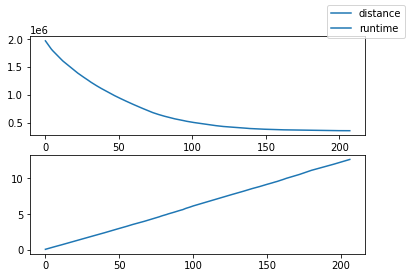

. 48703.155092 . 37573.736586 . 36478.373002 . 33876.772113 . 30524.620147 . 29019.035424 . 28724.942523 . 27059.634363 . 25265.528616 . 23967.590756 . 23088.968918 . 23127.849184 . 27792.801773 . 22316.954706 . 22348.279044 . 21810.508029 . 21922.300820 . 21064.818157 . 17827.718183 . 19286.169090 . 18459.654627 . 19400.613150 . 18679.717700 . 19564.892433 . 18292.195385 . 18506.168424 . 17541.212337 . 17650.531476 . 18166.700514 . 16726.420210 . 16883.723045 . 16180.772836 . 16437.033560 . 16358.701313 . 16225.056388 . 16386.318756 . 16348.281628 . 15970.292315 . 14960.810429 . 16500.766862 . 14812.020303 . 13706.248978 . 14269.361114 . 14087.318384 . 15095.869539 . 12763.875246 . 14556.359050 . 14915.022675 . 13175.765460 . 13134.534276 . 12235.177969 . 12531.867286 . 13256.263863 . 13391.545083 . 10540.607615 . 11454.564282 . 10950.077152 . 12018.829972 . 11216.286346 . 10275.063840 . 10118.429775 . 9896.290564 . 10016.578258 . 9749.127556 . 9430.432363 . 9254.520008 . 9308.489834 

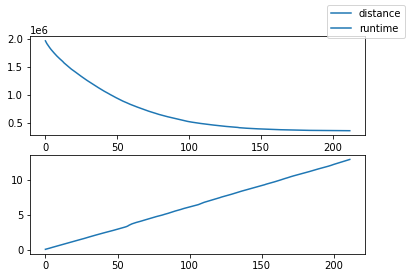

. 51266.013768 . 46109.952440 . 39061.006454 . 33041.260584 . 31877.405440 . 27137.371615 . 27851.905827 . 26837.355336 . 26660.143618 . 27050.138608 . 26379.729526 . 25934.879676 . 23579.816580 . 25973.426090 . 24159.831348 . 24075.433000 . 23779.313043 . 24330.384493 . 23783.043615 . 21587.558591 . 21818.043270 . 22036.159458 . 24433.925772 . 21564.708009 . 20495.547509 . 20282.382883 . 19527.321620 . 22116.936567 . 19255.242272 . 19509.601665 . 18560.882842 . 19000.855518 . 17872.773333 . 18242.112160 . 17782.893731 . 17420.980575 . 17932.052002 . 16751.403994 . 16774.073378 . 18911.808341 . 15472.593150 . 14946.171128 . 15427.914049 . 15233.556175 . 14524.383210 . 14202.954599 . 14352.507803 . 14316.687870 . 13732.872765 . 13538.921753 . 14550.233204 . 14134.575107 . 12953.606831 . 12582.665492 . 13399.637619 . 12080.965387 . 11957.190212 . 12424.510625 . 11948.598571 . 12228.915655 . 11655.809029 . 11759.433427 . 11032.227023 . 10843.151798 . 11584.001337 . 11310.029650 . 10928.84

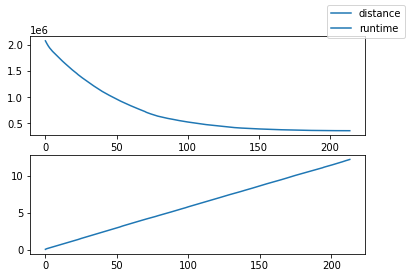

. 56965.927797 . 30953.159859 . 31650.175274 . 31698.396757 . 29523.348978 . 32636.346783 . 28837.681305 . 28056.375584 . 27133.047874 . 25380.646273 . 24712.282053 . 25731.940176 . 23134.287692 . 23340.196782 . 22491.181180 . 22563.469956 . 22379.398394 . 21566.890570 . 23017.332384 . 23214.561340 . 23563.736587 . 22295.139850 . 21206.618552 . 22428.054691 . 21636.637100 . 19925.034799 . 19350.295738 . 18257.621793 . 17638.039194 . 18368.276313 . 17865.030556 . 17966.274215 . 18882.254010 . 18380.145048 . 17453.623189 . 17669.268038 . 16885.101655 . 16557.464950 . 15594.196976 . 15226.036936 . 15924.874410 . 15489.977925 . 15419.968516 . 15492.366774 . 15460.429567 . 15682.139008 . 15905.588209 . 14955.157723 . 13827.465674 . 13783.679993 . 13880.086630 . 13740.637125 . 13632.078101 . 13565.657701 . 12411.404453 . 13304.541816 . 11486.399335 . 11502.454479 . 12140.804876 . 11730.341162 . 11365.009581 . 11298.345650 . 11398.781253 . 10131.626556 . 11340.201198 . 10844.366862 . 10548.19

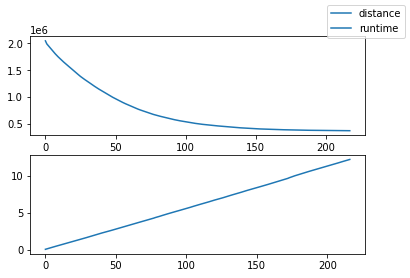

. 45064.886986 . 31170.071478 . 31247.053237 . 33351.957358 . 28906.462114 . 28294.715736 . 27702.878675 . 27063.360378 . 26381.432653 . 25895.161578 . 25858.183521 . 25916.741699 . 25043.598308 . 25056.641760 . 25255.251549 . 25199.348469 . 21825.068280 . 23689.472977 . 21985.162788 . 22826.890793 . 22401.146290 . 23408.257768 . 22709.382721 . 22506.828365 . 20274.592562 . 19189.705962 . 18051.137304 . 17644.606192 . 18487.766451 . 17670.083349 . 16711.923807 . 16617.441544 . 16489.489704 . 17563.237551 . 17224.618246 . 17106.160630 . 16501.842009 . 15763.532980 . 15659.612383 . 14741.734241 . 18131.351562 . 15010.293382 . 17606.172986 . 14202.864339 . 14010.918100 . 14312.271234 . 13811.200826 . 13463.603360 . 13991.823923 . 13837.020538 . 13826.119358 . 14496.921301 . 13815.171691 . 13982.880083 . 13288.043295 . 13341.047368 . 14270.450887 . 13178.391853 . 12475.115993 . 12063.063968 . 12440.967672 . 12357.155124 . 11920.085200 . 12896.474172 . 10227.302153 . 9626.132439 . 11518.824

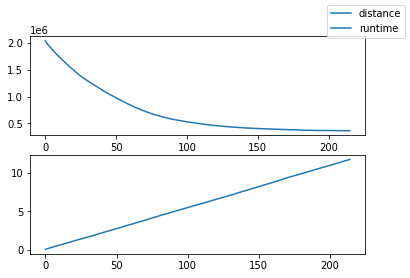

--------------------------------------------------------------------------------


In [89]:
tsp = main()